# Bitcoin Sentiment Analysis - News Article EDA

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from data.time_series_functions import missing_dates_by_year

import pickle

### Import News Articles

In [2]:
# Open pickled links
with open('sentiment_pickles/pickle_bitcoin_magazine_df.pickle', 'rb') as read_file:
    df_bitcoin_magazine = pickle.load(read_file)
    
with open('sentiment_pickles/pickle_bitcoin_news_df.pickle', 'rb') as read_file:
    df_bitcoin_news = pickle.load(read_file)
    
with open('sentiment_pickles/pickle_coin_telegraph_df.pickle', 'rb') as read_file:
    df_coin_telegraph = pickle.load(read_file)

with open('sentiment_pickles/pickle_crypto_slate_df.pickle', 'rb') as read_file:
    df_crypto_slate = pickle.load(read_file)

In [3]:
# Drop any duplicate articles
df_bitcoin_magazine.drop_duplicates(inplace=True)
df_bitcoin_news.drop_duplicates(inplace=True)
df_coin_telegraph.drop_duplicates(inplace=True)
df_crypto_slate.drop_duplicates(inplace=True)

### Clean Up the Article Content for LDA

In [4]:
def clean_content(df, to_replace):
    """
    Replace with ' ' in the 'body' column for a list of regex expressions.
    """
    for tr in to_replace:
        df['body'] = df['body'].str.replace(tr, ' ')
    return df

In [5]:
"""
This cell includes a list of regular expressions that need to be removed from the news article data.
Each website has different nuances for extraneous information. This includes things like disclaimers,
image credits, recommended articles, and other information that will distor topic modeling and
sentiment analysis.
"""

bitcoin_news_to_replace = ['\nDisclaimer:.*',
                           '\n.*Let us know .*',
                           '\nWhat do you think about.*',
                           '\nBitcoin News is growing fast.*',
                           '\nGet our news feed on your site.*',
                           '\nNeed to calculate your bitcoin holdings.*',
                           '\nExpress yourself freely at.*',
                           '\n.*widget service.*',
                           '\n.*Check our tools section.*',
                           '\nDo you like to research and read about Bitcoin.*'
                           '\nAlso Read:.*\n',
                           'Bitcoin.com',
                           '\n.*{.*}.*\n',
                           '\nImages via.*',
                           '\nImages courtesy.*',
                           '\nImage Credits.*'
                          ]

crypto_slate_to_replace = ['\nCommitment to Transparency:.*',
                           '\nDisclaimer:.*',
                           '\nBREAKING:.*\n',
                           '\nGet an edge on the cryptoasset market',
                           '\nAccess more crypto insights and context in every article as a paid member of CryptoSlate Edge.',
                           '\n.*{.*}.*\n',
                           'CryptoSlate'
                          ]

bitcoin_magazine_to_replace = ['\nTrading and investing in digital assets like bitcoin.*',
                               '\nThis is a guest post.*',
                               '\nThis op-ed is a guest post.*',
                               '\n.*The views expressed are.*',
                               '\n.*{.*}.*\n',
                               'Bitcoin Magazine',
                               'BitcoinMagazine'
                             ]

coin_telegraph_to_replace = ['\nThe views and opinions expressed here.*',
                             '\nMarket data is provided by.*',
                             'Coin Telegraph',
                             'CoinTelegraph',
                             'cointelegraph',
                             'Cointelegraph'
                            ]

In [6]:
df_bitcoin_news = clean_content(df_bitcoin_news, bitcoin_news_to_replace)
df_crypto_slate = clean_content(df_crypto_slate, crypto_slate_to_replace)
df_bitcoin_magazine = clean_content(df_bitcoin_magazine, bitcoin_magazine_to_replace)
df_coin_telegraph = clean_content(df_coin_telegraph, coin_telegraph_to_replace)

<ipython-input-4-75b7b59c17c8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace(tr, ' ')


### Create Concatenated News Article Dataset

In [7]:
# Concatenate to single dataframe
all_articles = pd.concat([df_bitcoin_magazine, df_bitcoin_news, df_coin_telegraph, df_crypto_slate]).reset_index(drop=True)

In [8]:
# Create lowercase columns, tokenize body, and count total words in body
all_articles['body_lower'] = all_articles['body'].str.lower()
all_articles['title_lower'] = all_articles['title'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
all_articles['tokenized'] = all_articles.apply(lambda row: tokenizer.tokenize(row['body_lower']), axis=1)
all_articles['num_words'] = all_articles.apply(lambda row: len(row['tokenized']), axis=1)

In [9]:
# Count instances of bitcoin/btc and calculate percentage
all_articles['bitcoin_body_count'] = (all_articles['body_lower'].str.count('bitcoin') +
                                      all_articles['body_lower'].str.count('btc'))
all_articles['bitcoin_body_perc'] = all_articles['bitcoin_body_count'] / all_articles['num_words']
all_articles['bitcoin_in_title'] = (all_articles['title_lower'].str.contains('bitcoin') |
                                    all_articles['title_lower'].str.contains('btc'))

In [10]:
# Count instances of bitcoin/btc and calculate percentage
all_articles['bitcoin_body_count'] = (all_articles['body_lower'].str.count('bitcoin') +
                                 all_articles['body_lower'].str.count('btc'))
all_articles['bitcoin_body_perc'] = all_articles['bitcoin_body_count'] / all_articles['num_words']
all_articles['bitcoin_in_title'] = (all_articles['title_lower'].str.contains('bitcoin') |
                                    all_articles['title_lower'].str.contains('btc'))

### Explore News Article Dataset

In [11]:
all_articles.describe()

,num_words,bitcoin_body_count,bitcoin_body_perc
count,34765.000000,34765.000000,34748.000000
mean,630.392119,9.822925,0.017473
std,435.332213,9.814996,0.015533
min,0.000000,0.000000,0.000000
25%,373.000000,3.000000,0.005540
50%,516.000000,7.000000,0.014760
75%,736.000000,14.000000,0.026490
max,12007.000000,156.000000,0.333333


In [12]:
def plot_histogram(df, x, title, xlim=None, hue=None, bins='auto'):
    fig, ax = plt.subplots(figsize=[20, 6])
    plt.suptitle(title, fontweight='bold', fontsize=22)
    sns.histplot(data=df, x=x, hue=hue,  ax=ax, kde=True, bins=bins)
    if xlim:
        plt.xlim(xlim)
    plt.show();

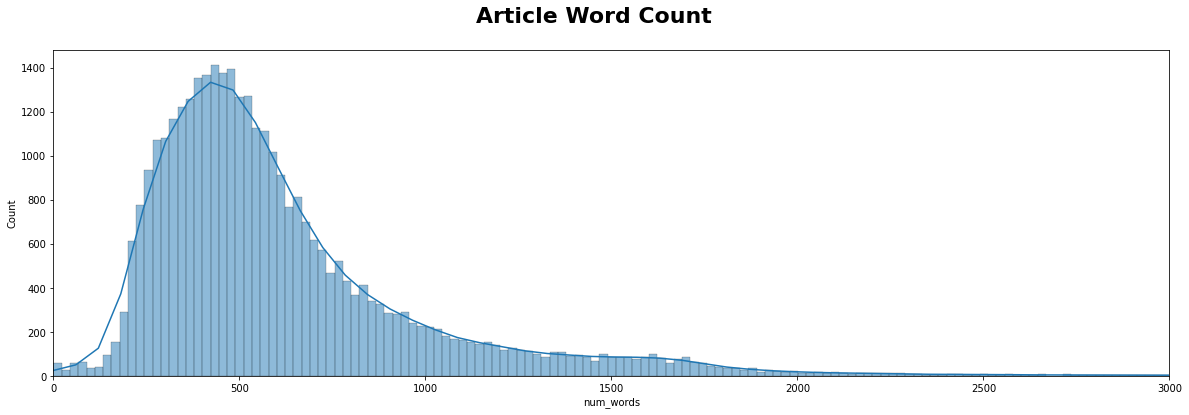

In [13]:
plot_histogram(all_articles, 
               x='num_words', 
               title='Article Word Count',
               xlim=(0,3000)
              )

### Example Articles

#### 200-225 words

In [14]:
ex_200_225 = all_articles[(all_articles['num_words'] > 200) & (all_articles['num_words'] < 225)].sample(1)

print(ex_200_225['website'].iloc[0], '\n')
print(ex_200_225['title'].iloc[0], '\n')
print(ex_200_225['body'].iloc[0])

Coin Telegraph 

Venezuelans Continue to Seek Refuge in Bitcoin, Other Cryptocurrencies 

It’s no secret that Venezuela is in an economic tailspin. The country famously sought to end corruption (a la India in November 2016) by removing the 100 Bolivar note from circulation.
The widespread panic that the already nearly valueless currency would now be worthless led to massive lines and protest from citizens seeking the protection of assets.
At that time, many Venezuelans began seeking refuge from the economic turmoil by investing in cryptocurrencies. The market responded and Venezuela’s first Bitcoin exchange was opened.
However, according to a recent report by Bloomberg this week, the demand for cryptocurrencies in Venezuela has continued to soar. This week’s trading volume on Bitcoin soared again to over $1.3 mln, nearly doubling the levels from two months ago.
The volatility of cryptocurrencies is minimal, compared to the massive devaluation of the country’s local currency (6000 Boliv

#### 100-125 words

In [15]:
ex_100_125 = all_articles[(all_articles['num_words'] >= 100) & (all_articles['num_words'] < 125)].sample(1)

print(ex_100_125['website'].iloc[0], '\n')
print(ex_100_125['title'].iloc[0], '\n')
print(ex_100_125['body'].iloc[0])

Coin Telegraph 

Joey Smith: Interests in Crypto, Education, Experience 

Joey Smith, born 1996, currently living in Atlanta
Georgia Perimeter College
Joey is the president and co-founder of Quickybit hosting. Joey is also the author of the book The Bitcoin Revolution. He is a breaking news correspondent for Bitcoinvox News.
Cryptocurrencies, social media, internet marketing, MMA, investing
Joey first found out about Bitcoin in 2009, when he was only 13 years old reading on Reddit. A week after first reading about how to mine Bitcoin, he began mining. He currently has three Bitcoin mining operations in the Atlanta area.
Joey is a Bitcoin advocate and tries to introduce new people to the currency and its surrounding community as a reporter and an author.


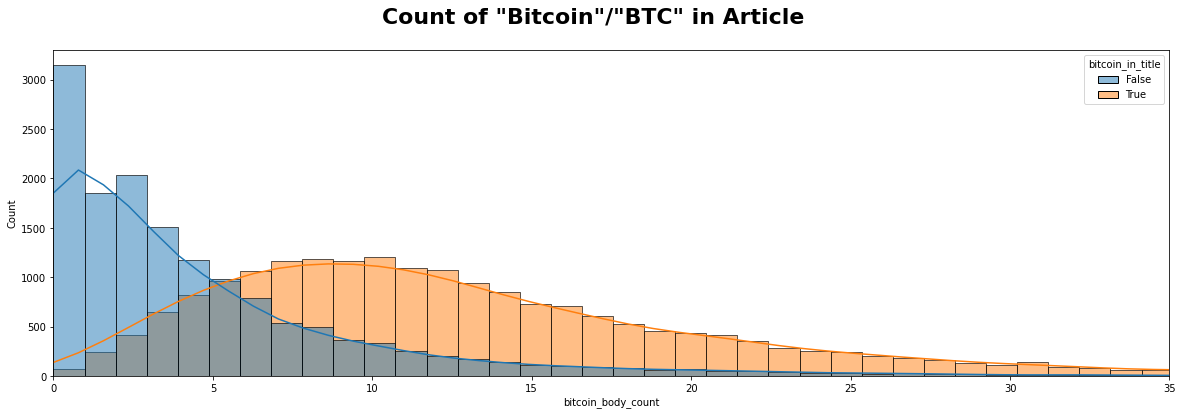

In [16]:
plot_histogram(all_articles, 
               x='bitcoin_body_count', 
               title='Count of "Bitcoin"/"BTC" in Article',
               xlim=(0,35),
               hue='bitcoin_in_title', 
               bins=160
              )

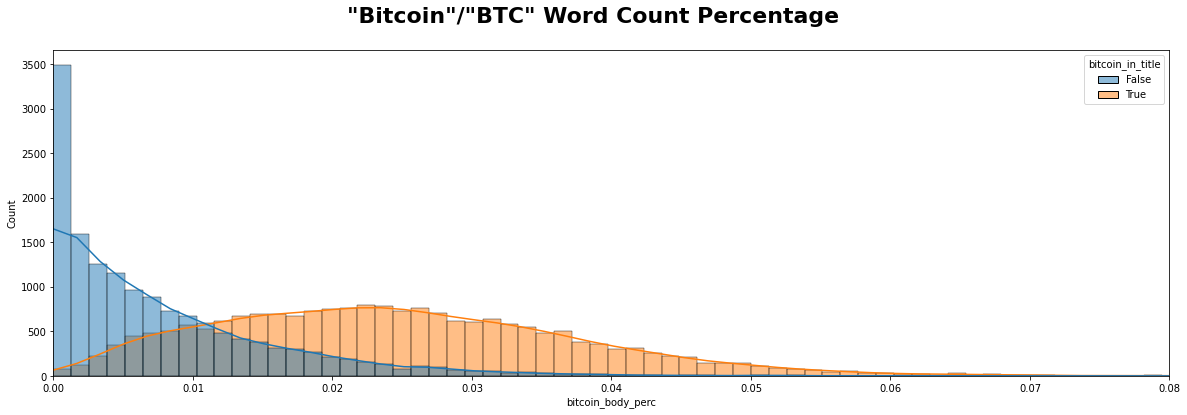

In [17]:
plot_histogram(all_articles, 
               x='bitcoin_body_perc',  
               title='"Bitcoin"/"BTC" Word Count Percentage',
               hue='bitcoin_in_title',
               xlim=(0,0.08)
              )

### Drop Short and Unrelated Articles from Dataset

I will perform the following filtering steps:
- I will drop all articles less than 200 words, as articles shorter than this are not enough to warrant sentiment analysis. 
- I will drop articles that do not contain "Bitcoin" or "BTC" in the title, unless the body of the article has greater than 1% word count percentage devoted to "Bitcoin" or "BTC."
- I will drop all articles with less than 0.5% occurrence of "Bitcoin" or "BTC" in the body of the article.

In [18]:
mask = ((all_articles['num_words'] >= 200) &
        (~((all_articles['bitcoin_in_title'] == False) & (all_articles['bitcoin_body_perc'] < 0.01))) &
        (all_articles['bitcoin_body_perc'] >= 0.005))
        

bitcoin_articles = all_articles[mask]

In [19]:
len(bitcoin_articles)

22778

### Scraped Articles by Date

In [20]:
articles_by_date = bitcoin_articles.groupby('date')[['title']].count().reset_index()

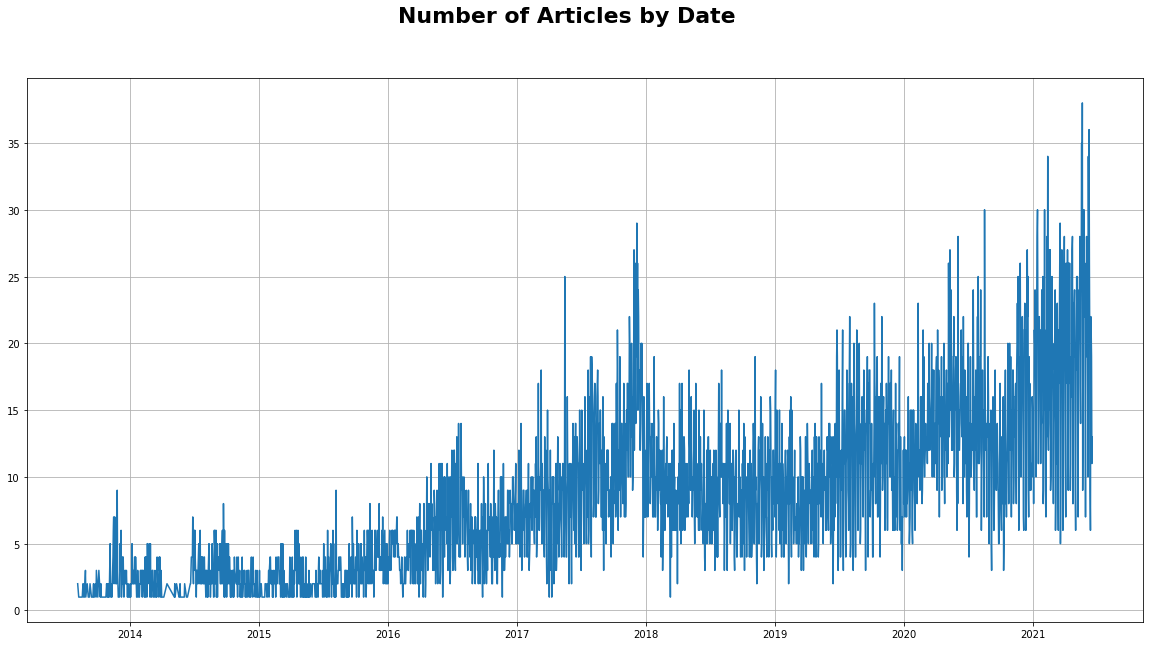

In [21]:
fig = plt.figure(figsize=(20,10))
plt.suptitle('Number of Articles by Date', fontweight='bold', fontsize=22)
plt.grid(True)
plt.plot(articles_by_date['date'], articles_by_date['title']);

In [22]:
missing_dates, missing_dates_df = missing_dates_by_year(articles_by_date, 'date', 'title')

In [23]:
missing_dates_df

,year,missing_dates
0,2013,49
1,2014,87
2,2015,42
3,2016,3


### Filter Dataset to 2017 and After
The first year with no dates with 0 articles is 2017. I will focus my topic modeling and sentiment analysis on data from 2017 and later in an attempt to avoid the issues associated with sparse data.

In [24]:
bitcoin_articles = bitcoin_articles[bitcoin_articles['date'] >= datetime(2017, 1, 1).date()]

len(bitcoin_articles)

18897

### Pickle the Data for Modeling

In [25]:
# Pickle the filtered dataset for modeling
with open('sentiment_pickles/pickle_articles_modeling.pickle', 'wb') as to_write:
    pickle.dump(bitcoin_articles, to_write)